In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import torch
import numpy as np
import chnet.cahn_hill as ch
import matplotlib.pyplot as plt
from ipywidgets import interact
from toolz.curried import pipe, curry
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel
warnings.filterwarnings('ignore')

In [3]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=7)

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Generate Data

In [4]:
nsamples = 1000 # no. of samples
dim_x = 101
dim_y = dim_x
sim_steps = 8000 # simulation steps
dx = 0.25 # delta space_dim
dt = 0.01 # delta time
gamma = 1.0 # interface energy
device = torch.device("cuda:0")

In [5]:
domain = [-1.1, 1.1]
n_states = 5
basis = LegendreBasis(n_states, domain)
init_data1 = init_unif(nsamples//2, dim_x, dim_y, seed=354875)
init_data2 = init_norm(nsamples//2, dim_x, dim_y, seed=982632)
init_data = np.concatenate([init_data1, init_data2], axis=0)

In [1]:
%%time
x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=100, device=device)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.58 µs


In [120]:
%%time
init_data1 = init_unif(25, dim_x, dim_y, seed=938645)
init_data2 = init_norm(25, dim_x, dim_y, seed=234580)
init_data = np.concatenate([init_data1, init_data2], axis=0)
x_val = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)
y_val = ch.ch_run_torch(x_val, dt=dt, gamma=gamma, dx=dx, sim_step=100, device=device)

CPU times: user 3.28 s, sys: 1.78 s, total: 5.06 s
Wall time: 5.05 s


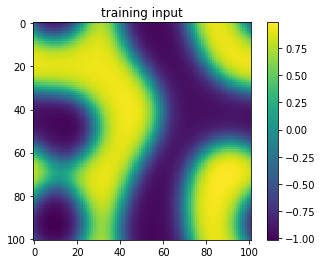

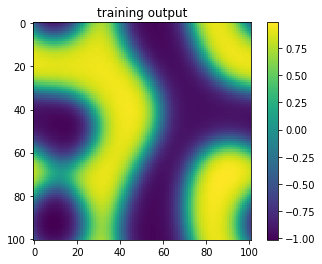

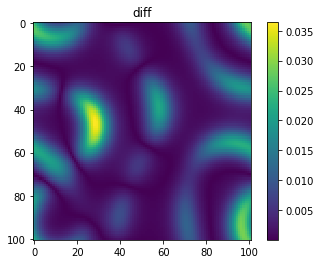

In [121]:
draw_im(x_data[0], "training input")
draw_im(y_data[0], "training output")

draw_im(np.fabs(x_data[0]-y_data[0]), "diff")

# To generate MKS coefficients from data...

In [14]:
nsamples = 1000
x_data = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]
y_data = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]

x_val = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]
y_val = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]

In [8]:
n_states = 11
domain = (-1.1, 1.1)
basis = LegendreBasis(n_states, domain)
model = MKSLocalizationModel(basis)

In [9]:
%%time
model.fit(x_data, y_data)

CPU times: user 2min 13s, sys: 11 s, total: 2min 24s
Wall time: 9.34 s


In [10]:
%%time
y_train_pred = model.predict(x_data)

CPU times: user 1min 27s, sys: 8.71 s, total: 1min 36s
Wall time: 7.38 s


In [11]:
print(rmserror(y_train_pred, y_data))
print(rmserror(y_train_pred, x_data))

0.0005894800015001691
0.016786952114891465


In [15]:
%%time
y_pred = model.predict(x_val)

CPU times: user 1min 27s, sys: 8.7 s, total: 1min 36s
Wall time: 7.34 s


In [16]:
print(rmserror(y_pred, y_val))
print(rmserror(y_pred, x_val))

0.00060092649020681
0.01681933566619044


In [17]:
coeff = model.coef_
@interact
def draw(i = (0,n_states-1)):
    plt.imshow(cropper(coeff[:,:,i]))
#     plt.imshow(coeff[:,:,i])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

In [19]:
# coeff500 = coeff.copy()
# coeff5000 = coeff.copy()
# coeff8000 = coeff.copy()

In [20]:
# for i in range(n_states):
#     print(i, rmserror(coeff5000[...,i], coeff8000[...,i]))

## Predicting future timesteps using same kernels

In [23]:
%%time
steps = 10
y_pred = x_val.copy()
print(0, y_pred.shape, rmserror(y_pred, y_val))
for step in range(steps):
    try:
        y_pred = model.predict(y_pred)
        print(step+1, y_pred.shape, rmserror(y_pred, y_val))
    except Exception as err:
        print(step, err)
        break

0 (1000, 101, 101) 0.016834531263357332
1 (1000, 101, 101) 0.00060092649020681
2 (1000, 101, 101) 0.016248064111522652
3 (1000, 101, 101) 0.03943397622210793
3 X must be within the specified domain
CPU times: user 4min 25s, sys: 26.6 s, total: 4min 52s
Wall time: 22.7 s
